Andrew Dodd, 3/6/21

## Assignment 2: Overview
### Part 1:
Four search algos:
1. randomized hill climbing
2. simulated annealing
3. a genetic algorithm
4. MIMIC

Three optimization problems:
1. 4 Peaks (GA)
2. K-color problem (MIMIC)
3. Count Ones (SA)

### Part 2:
Use neural net provided by mlrose, solve 
_________

In [3]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time
import random

In [106]:
def build_dists(n):
    pts = []
    for i in range(n+1):
        x, y = random.randint(1,10), random.randint(1,10)
        if (x,y) in pts: continue
        pts.append((x,y))
        
    dists = []
    for i in range(n):
        for j in range(n):
            if i == j: continue
            dists.append((i, j, euclid(pts[i], pts[j])))
    return dists

def build_pts(n):
    pts = []
    for i in range(n+1):
        x, y = random.randint(1,10), random.randint(1,10)
        if (x,y) in pts: continue
        pts.append((x,y))
    return pts

def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    
n=10
dists = build_dists(n)
coords = build_pts(n)

fitness_coords = mlrose.TravellingSales(coords = coords)
problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
n_iters = list(range(1, 15))

In [107]:
ga_fitnesses = []
ga_pop_size = 200
for i in n_iters:
    ave = []
    for j in range(2):
        best_state, best_fitness = mlrose.genetic_alg(problem_fit, pop_size=ga_pop_size, max_iters=i)
        ave.append(best_fitness)
    ga_fitnesses.append(sum(ave)/len(ave))

In [108]:
sa_fitnesses = []
sched = mlrose.GeomDecay(init_temp=1, decay=0.99, min_temp=0.001)
for i in n_iters:
    ave = []
    for j in range(2):
        best_state, best_fitness = mlrose.simulated_annealing(problem_fit, schedule=sched, 
                                                              max_attempts=20, max_iters=i)
        ave.append(best_fitness)
    sa_fitnesses.append(sum(ave)/len(ave))

In [109]:
rhc_fitnesses = []
for i in n_iters:
    ave = []
    for j in range(2):
        best_state, best_fitness = mlrose.random_hill_climb(problem_fit, max_iters = i, restarts=10)
        ave.append(best_fitness)
    rhc_fitnesses.append(sum(ave)/len(ave))

In [110]:
mimic_fitnesses = []
for i in n_iters:
    ave = []
    for j in range(2):
        best_state, best_fitness = mlrose.mimic(problem_fit, pop_size=200, max_iters = i)
        ave.append(best_fitness)
    mimic_fitnesses.append(sum(ave)/len(ave))
# mimic_fitnesses.extend([mimic_fitnesses[-1]]*(49-18))
print(len(mimic_fitnesses))

14


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Fitness')]

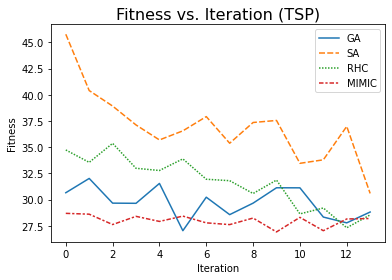

In [111]:
f, ax = plt.subplots(1,1, figsize=(6,4))
d = {'GA': ga_fitnesses,
     'SA': sa_fitnesses,
     'RHC': rhc_fitnesses,
     'MIMIC': mimic_fitnesses}
sns.lineplot(data=pd.DataFrame(d))
ax.set_title("Fitness vs. Iteration (TSP)", fontsize=16)
ax.set(xlabel='Iteration', ylabel='Fitness')

In [115]:

ga_times = []
sa_times = []
rhc_times = []
mimic_times = []

def get_time(problem_fit, algo, opt, sz, find_best=False):
    cnt = 0
    best_fitness = 100000
    tic = time()
    fn_evals = 0
    while best_fitness > opt:
        if algo == 'ga':
            best_state, best_fitness, curve = mlrose.genetic_alg(problem_fit, max_iters=10, curve=True)
            fn_evals = len(curve) * 200 * 5
        elif algo == 'mimic':
            best_state, best_fitness, curve = mlrose.mimic(problem_fit, pop_size=200, max_iters=3, curve=True)
            fn_evals = len(curve) * 50 * 5
        elif algo == 'rhc':
            best_state, best_fitness, curve = mlrose.random_hill_climb(problem_fit, max_iters = 5000, restarts=30, curve=True)
            fn_evals = len(curve) * sz * 5
        elif algo == 'sa':
            best_state, best_fitness, curve = mlrose.simulated_annealing(problem_fit, schedule=sched, max_iters=5000, curve=True)
            fn_evals = len(curve) * 5
        else:
            print("Failure")
        cnt += 1
        if find_best:
            print("Benchmark from MIMIC: ", best_fitness)
            return time() - tic, True, sz, fn_evals, best_fitness
        if (time() - tic > 180 and best_fitness > opt):
            return time() - tic, False, sz, fn_evals, best_fitness
    time_taken = time() - tic
    print(algo, int(best_fitness), round(time_taken,2))
    return time_taken, True, sz, fn_evals, best_fitness

# TODO change this to higher number if time allows
l1 = list(range(5,40,2))
print(l1)
for sz in l1:
    opt = 5000

    coords = build_pts(n)
    fitness_coords = mlrose.TravellingSales(coords = coords)
    problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
    
    best_state, best_fitness = mlrose.simulated_annealing(problem_fit, schedule=sched, max_iters=5000000)
    opt = best_fitness
    
    print("~~~~~ Desired opt: ", opt, "Sz: ", sz)
    
    problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
    ga_times.append(get_time(problem_fit=problem_fit, algo='ga', opt=opt, sz=sz))

    problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
    mimic_times.append(get_time(problem_fit=problem_fit, algo='mimic', opt=opt, sz=sz))
    
    problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
    sa_times.append(get_time(problem_fit=problem_fit, algo='sa', opt=opt, sz=sz))
    
    problem_fit = mlrose.TSPOpt(length=len(coords), coords=coords, maximize=False)
    rhc_times.append(get_time(problem_fit=problem_fit, algo='rhc', opt=opt, sz=sz))

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]
~~~~~ Desired opt:  25.36505818199175 Sz:  5
ga 25 4.21
mimic 25 0.42
sa 25 0.01
rhc 25 0.13
~~~~~ Desired opt:  40.64573113500036 Sz:  7
ga 35 0.48
mimic 35 0.52
sa 34 0.01
rhc 30 0.14
~~~~~ Desired opt:  38.04055307910045 Sz:  9
ga 34 0.45
mimic 32 0.54
sa 31 0.03
rhc 30 0.15
~~~~~ Desired opt:  42.295784403359875 Sz:  11
ga 35 0.44
mimic 34 0.45
sa 40 0.01
rhc 32 0.11
~~~~~ Desired opt:  44.312973575287195 Sz:  13
ga 43 0.95
mimic 41 0.52
sa 43 0.03
rhc 34 0.14
~~~~~ Desired opt:  34.431964085268966 Sz:  15
ga 33 5.84
mimic 33 0.51
sa 34 0.15
rhc 31 0.16
~~~~~ Desired opt:  40.482275088129484 Sz:  17
ga 33 0.46
mimic 32 0.51
sa 33 0.01
rhc 29 0.15
~~~~~ Desired opt:  47.27922307012501 Sz:  19
ga 39 0.44
mimic 31 0.46
sa 41 0.01
rhc 34 0.15
~~~~~ Desired opt:  36.72260908642428 Sz:  21
ga 32 0.44
mimic 30 0.5
sa 31 0.01
rhc 27 0.11
~~~~~ Desired opt:  30.881832902051926 Sz:  23
ga 28 0.42
mimic 28 0.44
sa 28 0.01
r

In [126]:
ga = pd.DataFrame(ga_times, columns = ['time', 'found', 'size','fn_evals',"he"])
sa = pd.DataFrame(sa_times, columns = ['time', 'found', 'size','fn_evals',"he"])
rhc = pd.DataFrame(rhc_times, columns = ['time', 'found', 'size','fn_evals',"he"])
mimic = pd.DataFrame(mimic_times, columns = ['time', 'found', 'size','fn_evals',"he"])
concatenated = pd.concat([ga.assign(dataset='ga'), 
                          sa.assign(dataset='sa'),
                          rhc.assign(dataset='rhc'),
                          mimic.assign(dataset='mimic'),
                         ])
concatenated = concatenated.rename(columns={'dataset':'algo'})
concatenated['fn_evals']/=1000

[Text(0.5, 0, 'Problem Size'),
 Text(0, 0.5, 'Thousands of Function Evals. (Approx.)')]

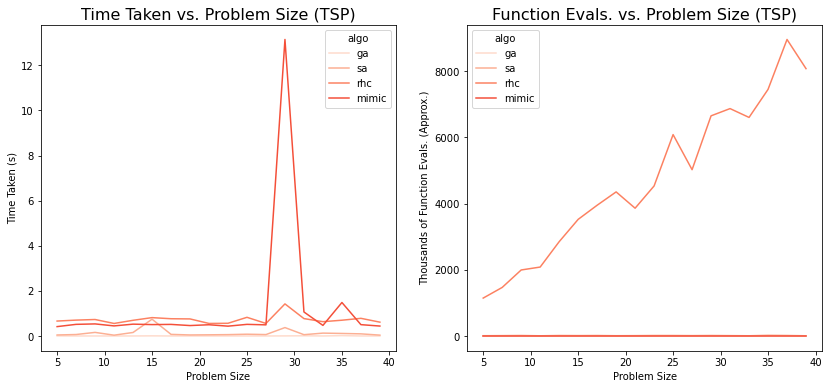

In [127]:
f, ax = plt.subplots(1,2, figsize=(14,6))
sns.set_palette("Reds")
sns.lineplot(x = 'size', y='time', hue='algo', data=pd.DataFrame(concatenated), ax=ax[0])
ax[0].set_title("Time Taken vs. Problem Size (TSP)", fontsize=16)
ax[0].set(xlabel='Problem Size', ylabel='Time Taken (s)')

sns.lineplot(x = 'size', y='fn_evals', hue='algo', data=pd.DataFrame(concatenated), ax=ax[1])
ax[1].set_title("Function Evals. vs. Problem Size (TSP)", fontsize=16)
ax[1].set(xlabel='Problem Size', ylabel='Thousands of Function Evals. (Approx.)')